In [8]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from PIL import Image
from pymongo import MongoClient
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from ajna_commons.flask.conf import DATABASE, MONGODB_URI
from ajna_commons.utils.images import generate_batch, get_imagens_recortadas

db = MongoClient(host=MONGODB_URI)[DATABASE]
file_histograms = os.path.join('..', 'data', 'exemplos_base_05_histograms.pkl')
file_pesos = os.path.join('..', 'data', 'exemplos_base_05_pesos.pkl')

In [9]:
filtro = {
    'metadata.contentType': 'image/jpeg',
    'metadata.predictions.bbox': {'$exists': True, '$ne': None},
    'metadata.carga.vazio': False
}
projection = ['metadata.carga.container', 'metadata.carga.container']

In [10]:
batch_gen = generate_batch(db, filtro=filtro, projection=projection, batch_size=4, limit=4)

In [11]:
batch, rows = next(batch_gen)

In [12]:
def extrai_pesos(lista):
    pesos = []
    for linha in lista:
        carga = linha.get('metadata').get('carga')
        if carga:
            container = carga.get('container')
            if container:
                tara = float(container[0].get('taracontainer').replace(',', '.'))
                peso = float(container[0].get('pesobrutoitem').replace(',', '.'))
                pesos.append(tara + peso)
    return pesos

pesos = extrai_pesos(rows)
print(len(rows), pesos)

4 [25940.0, 10996.288, 7762.1, 22312.0]


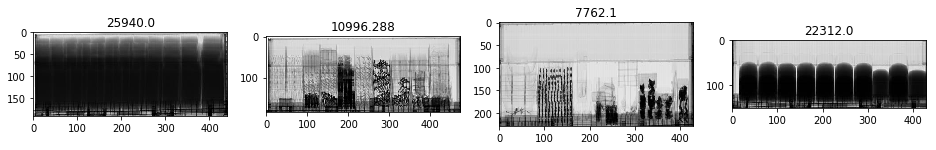

In [13]:
%matplotlib inline
def plot_pesos(images, rows):
    ncolumns = 4
    nrows = len(rows) // ncolumns
    fig=plt.figure(figsize=(16, 4 * nrows))
    for i, (image, row) in enumerate(zip(images, rows)):
        ax = fig.add_subplot(nrows, ncolumns, i + 1)
        ax.set(title=str(pesos[i]))
        plt.imshow(image[0])
    plt.show()
plot_pesos(batch, rows)

## Para treinar, vamos extrair histogramas e colocá-los no "X" e colocar os pesos no y. Para não ter que carregar milhares de imagens na memória, vamos puxar em batches.

### Pular as proximas duas células se já tiver X e y gravados

In [103]:
batch_gen = generate_batch(db, filtro=filtro, batch_size=100, limit=5000)
X = []
y = []
NBINS = 16
for images, rows in batch_gen:
    if not images:
        break
    for image, row in zip(images, rows):
        hist = np.histogram(image[0], bins=NBINS)
        pesos = extrai_pesos([row])
        if pesos and len(pesos) == 1:
            X.append(hist[0].tolist())
            y.append(pesos[0])
            sys.stdout.write('\r'+str(len(y)))
    

5000

In [114]:
joblib.dump(X, file_histograms)
joblib.dump(y, file_pesos)

['../data/exemplos_base_05_pesos.pkl']

## Aqui é possível recarregar o X e y salvo para economizar tempo ou treinar sem acesso ao Banco de Dados

In [14]:
X = joblib.load(file_histograms)
y = joblib.load(file_pesos)

In [15]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
reg = RandomForestRegressor()
reg.fit(Xtrain, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [16]:
ypred = reg.predict(Xtest)

In [17]:
error = mean_absolute_error(ytest, ypred)
mean = float(sum(y) / len(y))
print(error, mean)

1701.9414072 18274.759486400035


In [18]:
print('Erro médio absoluto {:.2f} / {:.0%}'.format(error, error / mean))

Erro médio absoluto 1701.94 / 9%


## Agora basta salvar o modelo em um pipeline (que faça o histograma)

In [19]:
from sklearn.pipeline import Pipeline
from padma.models.pipeline_classes import Histogram
"""
class Histogram():
    def fit(self, _):
        return self
    def transform(self, img_array):
        return [np.histogram(img_array, bins=NBINS)[0].tolist()]
"""    

new_padma_model = Pipeline([
    ('histogram', Histogram()),
    ('regressor', reg)
])

In [20]:
new_padma_model.predict(batch[0][0])

array([26670.5])

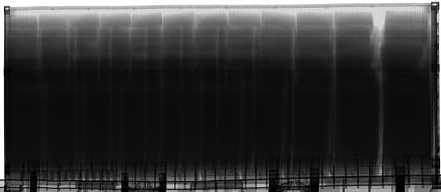

In [21]:
batch[0][0]

## Usar joblib para salvar modelo e fazer upload para PADMA

### O upload/publicação do modelo pode ser realizado na aplicação PADMA na tela modelos.  Aqui, está sendo utilizada request para acessar essa URL, tentar utilizar o modelo recebendo o erro, e depois fazendo upload do modelo e consultando novamente, para ver se o resultado bate com a consulta direta (o peso acima)


In [22]:
file_reg = os.path.join('..', 'data', 'rf_reg_pesos05.pkl')

In [23]:
joblib.dump(new_padma_model, file_reg)

['../data/rf_reg_pesos05.pkl']

In [24]:
saved_model = joblib.load(file_reg)

In [25]:
saved_model.predict(batch[0][0])

array([26670.5])

In [26]:
import requests
from json.decoder import JSONDecodeError
from ajna_commons.flask.conf import PADMA_URL
from ajna_commons.utils.images import PIL_tobytes
# sys.path.insert(0, os.path.join('..', 'virasana'))
# from virasana.integracao import get_service_password
# from virasana.integracao import consulta_padma
def consulta_padma(image, model):
    data = {}
    data['image'] = image
    headers = {}
    result = {'predictions': [], 'success': False}
    s = requests.Session()
    # username, password = get_service_password()
    # r = login(username, password, s)
    try:
        r = s.post(PADMA_URL + '/predict?model=' + model,
                   files=data, headers=headers)
        if r.status_code == 200:
            result = r.json()
        else:
            print(r.status_code)
    except JSONDecodeError as err:
        print('Erro em consulta_padma(JSON inválido) %s HTTP Code:%s ' %
                     (err, r.status_code))
    return result

In [39]:
r = consulta_padma(PIL_tobytes(batch[0][0]), 'rf_reg_pesos05.pkl')
print(r)

{'erro': 'Modelo não existente: rf_reg_pesos05.pkl.', 'success': False, 'modelos': ['index', 'naive', 'ssd', 'peso', 'vaziosvm', 'Pipeline_SVC.pkl', 'ping']}


In [40]:
pkl = open(file_reg,  'rb')
data = {'file': ('rf_reg_pesos05.pkl', pkl)}
r = requests.post(PADMA_URL + '/modelos', files=data)
print(r, r.text)

<Response [200]> <!DOCTYPE html>
<html>
  <head>
<meta charset="utf-8">
<meta http-equiv="X-UA-Compatible" content="IE=edge">
<meta name="viewport" content="width=device-width, initial-scale=1">
<link href="/static/css/bootstrap.min.css" rel="stylesheet">    
<link href="/static/css/font-awesome.min.css" rel="stylesheet" />
<link href="/static/css/jquery-ui.min.css" rel="stylesheet"> 
<style>
    .table {
        margin: auto;
    }
    th, td {
        text-align: center;
        color: #333;
    }
    td:hover{
        background-color:rgba(207, 207, 207, 0.692)
    }
    .modal {
        text-align: center;
        vertical-align: middle;
        height: 100%;
        width: 100%;
    }
    .modal-dialog {
        display: inline-block;
        text-align: left;
        vertical-align: middle;
    }
</style>

  </head>
  <body>
    
<nav class="navbar navbar-default">
  <div class="container-fluid">
    <div class="navbar-header">
      <button aria-controls="navbar" aria-expanded="

## Consultar padma

In [41]:
r = consulta_padma(PIL_tobytes(batch[0][0]), 'consulta')
print(r)

{'erro': 'Modelo não existente: consulta.', 'success': False, 'modelos': ['index', 'naive', 'ssd', 'peso', 'vaziosvm', 'Pipeline_SVC.pkl', 'rf_reg_pesos05.pkl', 'ping']}


In [42]:
r = consulta_padma(PIL_tobytes(batch[0][0]), 'rf_reg_pesos05.pkl')
print(r)

{'predictions': [26670.5], 'success': True}


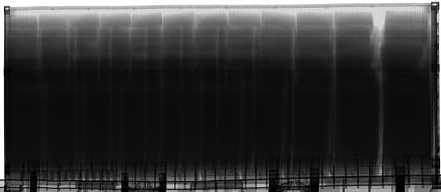

In [43]:
batch[0][0]